<a href="https://colab.research.google.com/github/Lisa-Tera/DATA_Aanalysis/blob/main/movie_EUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

여름철에 개봉하는 액션 및 공포 장르의 영화는 15세 관람가 등급보다 청소년 관람불가 등급일 때 관객이 더 많을 것이다

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 데이터 불러오기
train = pd.read_csv('movies_train.csv')
#test = pd.read_csv('movies_test.csv') print(test.isnull().sum())
# 결측치 확인
print(train.isnull().sum())

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64


In [ ]:
train= train[['genre', 'release_time', 'screening_rat', 'box_off_num']]

train['release_time'] = pd.to_datetime(train['release_time']).dt.month.astype(int) #year-month-day에서 month만 남도록 변경
train.head()



,genre,release_time,screening_rat,box_off_num
0,액션,11,청소년 관람불가,23398
1,느와르,11,청소년 관람불가,7072501
2,액션,6,15세 관람가,6959083
3,코미디,7,전체 관람가,217866
4,코미디,11,15세 관람가,483387


In [ ]:
unique_genres = train['genre'].unique()
print(unique_genres)
#'액션' '느와르' '공포' '서스펜스' '미스터리'

['액션' '느와르' '코미디' '다큐멘터리' '뮤지컬' '드라마' '멜로/로맨스' '공포' '서스펜스' '애니메이션' '미스터리'
 'SF']


In [ ]:
# 가설: 여름철 | 장르(액션,공포 등) | 청불 인 영화가 흥행할 것이다
train['genre_bi'] = train['genre'].apply(lambda x: 1 if x in ['액션', '느와르', '공포', '서스펜스', '미스터리'] else 0)
train['release_time_bi'] = train['release_time'].apply(lambda x: 1 if 7 <= x <= 9 else 0)
train['screening_rat_bi'] = train['screening_rat'].apply(lambda x: 1 if x == '청소년 관람불가' else 0 )

In [ ]:
#영화의 관객수가 많다는 어떤의미?
#영화의 최대 관객과 최소 관객의 차가 너무 큼
sorted_data = train.sort_values(by='box_off_num', ascending=False)
sorted_data

,genre,release_time,screening_rat,box_off_num,genre_bi,release_time_bi,screening_rat_bi
372,드라마,12,12세 관람가,14262766,0,0,0
362,느와르,7,15세 관람가,12983841,1,1,0
530,코미디,1,15세 관람가,12811435,0,0,0
498,액션,7,15세 관람가,12706663,1,1,0
460,드라마,9,15세 관람가,12323595,0,1,0
...,...,...,...,...,...,...,...
481,드라마,11,15세 관람가,36,0,0,0
410,멜로/로맨스,11,청소년 관람불가,10,0,0,1
338,멜로/로맨스,9,청소년 관람불가,8,0,1,1
324,드라마,9,청소년 관람불가,2,0,1,1


In [ ]:
top_10_avg = train['box_off_num'][train['box_off_num'] > train['box_off_num'].quantile(0.9)].mean()
mid_10_50_avg = train['box_off_num'][(train['box_off_num'] > train['box_off_num'].quantile(0.5)) &
                                     (train['box_off_num'] <= train['box_off_num'].quantile(0.9))].mean()
bottom_50_avg = train['box_off_num'][train['box_off_num'] <= train['box_off_num'].quantile(0.5)].mean()

top_10_avg, mid_10_50_avg, bottom_50_avg

(5043424.733333333, 506481.5875, 2493.286666666667)


상위 10% | 상위 10~50% | 하위 50%의 관객 수


---



In [ ]:
#상위 25% 정도는 약 50만명정도로 25%를 기준으로 흥행했다고 가정
threshold = train['box_off_num'].quantile(0.75)
print("임계값 (상위 25%):", threshold)


train['box_off_num_binary'] = train['box_off_num'].apply(lambda x: 1 if x > threshold else 0)
train['box_off_num_binary'].value_counts()

임계값 (상위 25%): 479886.75


,count
box_off_num_binary,
0,450
1,150


In [ ]:
'''from sklearn.utils import resample
train_class_0 = train[train['box_off_num_binary'] == 0]
train_class_1 = train[train['box_off_num_binary'] == 1]
train_class_1_upsampled = resample(train_class_1, replace=True, n_samples=450, random_state=42)
train_balanced = pd.concat([train_class_0, train_class_1_upsampled])
train_balanced'''

"from sklearn.utils import resample\ntrain_class_0 = train[train['box_off_num_binary'] == 0]\ntrain_class_1 = train[train['box_off_num_binary'] == 1]\ntrain_class_1_upsampled = resample(train_class_1, replace=True, n_samples=450, random_state=42)\ntrain_balanced = pd.concat([train_class_0, train_class_1_upsampled])\ntrain_balanced"

오버샘플링 시 결과값이 더 안좋음... 실패

In [ ]:
group_1_in_train = train[(train['genre_bi'] == 1) & (train['release_time_bi'] == 1) & (train['screening_rat_bi'] == 1)]
print("train 데이터에서 group_1 조건을 만족하는 샘플 수:", len(group_1_in_train))


train 데이터에서 group_1 조건을 만족하는 샘플 수: 24


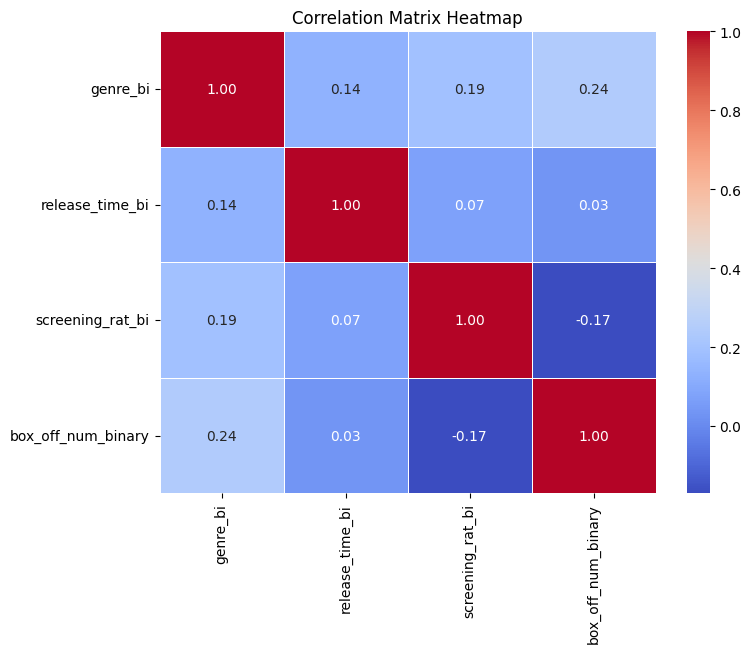

In [ ]:
#히트맵으로 각각의 상관관계 표현
correlation_matrix = train[['genre_bi', 'release_time_bi', 'screening_rat_bi','box_off_num_binary']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

heatmap 값이 너무 낮아 경우의 수로 항목을 나눈 뒤 비교

In [ ]:
target_col = 'box_off_num_binary'
variable_groups = [
    ['genre_bi', 'release_time_bi'],
    ['release_time_bi', 'screening_rat_bi'],
    ['genre_bi', 'release_time_bi'],
    ['genre_bi', 'release_time_bi', 'screening_rat_bi']
]

# Calculate and store the correlation of each group with the target variable
correlation_results = {}
for i, variables in enumerate(variable_groups, 1):
    # Calculate the mean of the selected group as a combined feature
    combined_feature = train[variables].mean(axis=1)
    # Calculate correlation with the target column
    correlation = combined_feature.corr(train[target_col])
    correlation_results[f'Group {i} ({", ".join(variables)})'] = correlation

# Display the correlation results
correlation_results

{'Group 1 (genre_bi, release_time_bi)': 0.17600016741997726,
 'Group 2 (release_time_bi, screening_rat_bi)': -0.09713017158149025,
 'Group 3 (genre_bi, release_time_bi)': 0.17600016741997726,
 'Group 4 (genre_bi, release_time_bi, screening_rat_bi)': 0.03605689308399914}

# 그래프

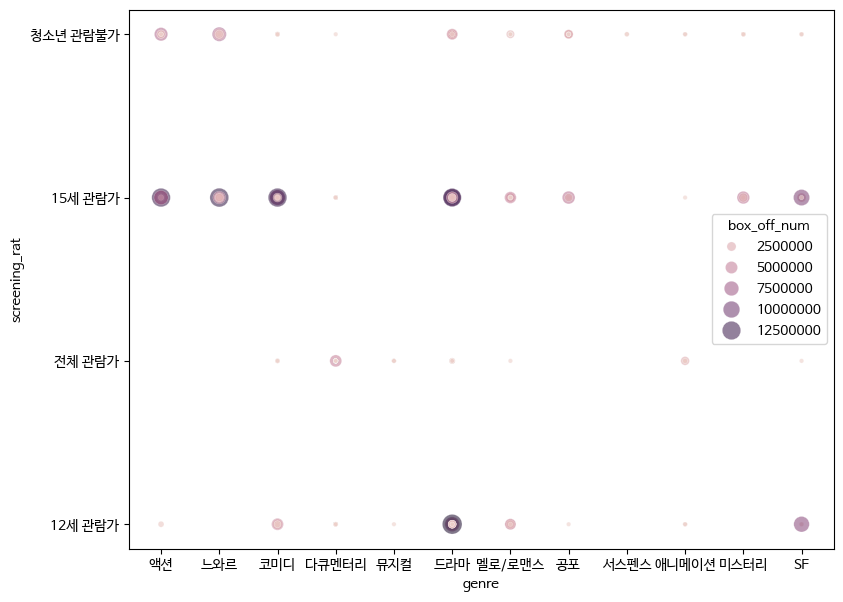

In [ ]:

plt.rc('font', family='NanumBarunGothic')


train['season'] = train['release_time'].apply(lambda x: '봄' if x in [3, 4, 5] else
                                      ('여름' if x in [6, 7, 8] else
                                       ('가을' if x in [9, 10, 11] else '겨울')))

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.scatterplot(data=train, x='genre', y='screening_rat', size='box_off_num', hue='box_off_num', alpha=0.6, sizes=(10, 200))
plt.legend(title='box_off_num')
plt.show()


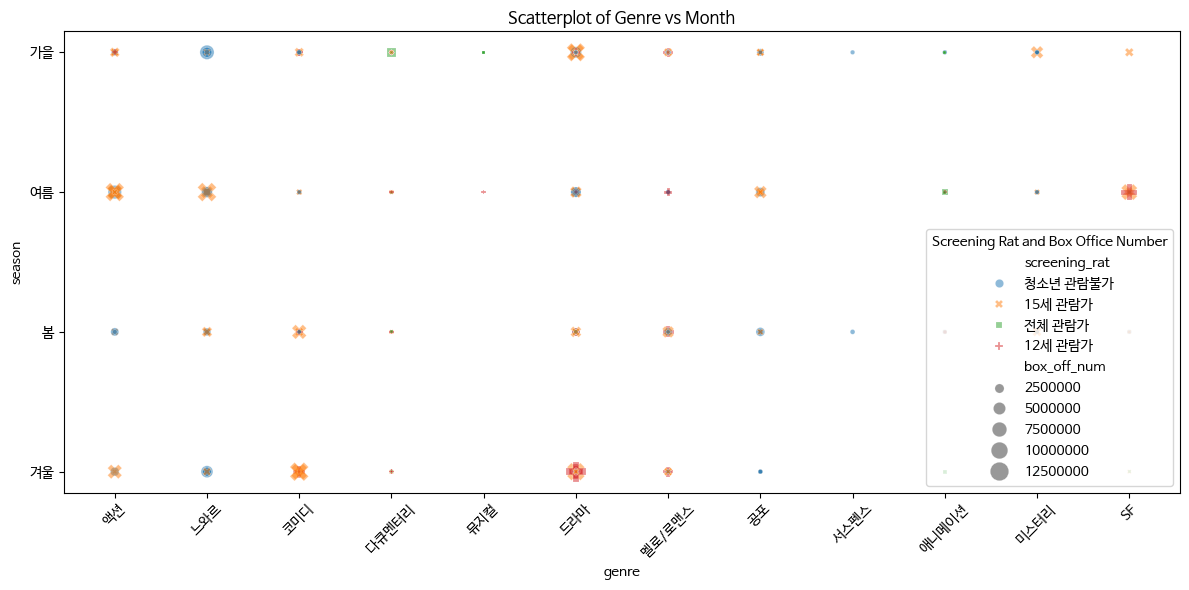

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='genre', y='season',
                style='screening_rat', size='box_off_num',
                hue='screening_rat', alpha=0.5, sizes=(10, 200))

plt.title('Scatterplot of Genre vs Month')
plt.legend(title='Screening Rat and Box Office Number')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

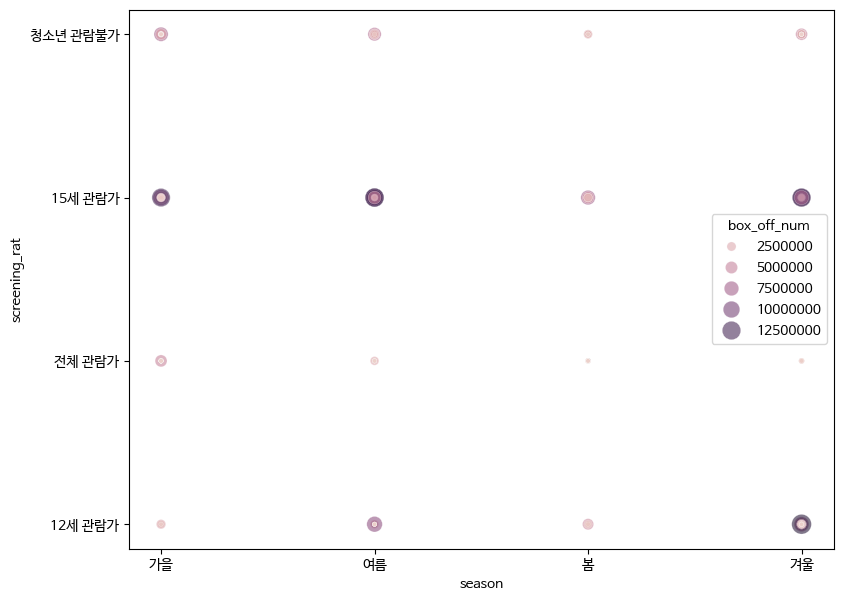

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.scatterplot(data=train, x='season', y='screening_rat', size='box_off_num', hue='box_off_num', alpha=0.6, sizes=(10, 200))
plt.legend(title='box_off_num')
plt.show()

# 모델

In [ ]:
X = train[['genre_bi', 'release_time_bi', 'screening_rat_bi']]
y = train['box_off_num_binary']

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit_transform은 학습 데이터에만 적용
X_val = scaler.transform(X_val)          # transform만 검증 데이터에 적용

# 딥러닝 모델 구성
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input 레이어
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7617 - loss: 2.2249 - val_accuracy: 0.7500 - val_loss: 1.9175
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7473 - loss: 2.2348 - val_accuracy: 0.7500 - val_loss: 1.9194
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7176 - loss: 2.2578 - val_accuracy: 0.7500 - val_loss: 1.9359
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7551 - loss: 2.1369 - val_accuracy: 0.7500 - val_loss: 1.9229
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7654 - loss: 2.0260 - val_accuracy: 0.7500 - val_loss: 1.9249
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7615 - loss: 2.3152 - val_accuracy: 0.7500 - val_loss: 1.9260
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 1.9533 - val_accuracy: 0.7500 - val_loss: 1.9227
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7640 - loss: 2.0214 - val_accuracy: 0.7500 - val_loss

In [ ]:
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 데이터 준비
X = train[['genre_bi', 'release_time_bi', 'screening_rat_bi']]
y = train['box_off_num_binary']

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 딥러닝 모델 구성
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일 (학습률 설정)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size=16  # 배치 크기 줄이기
)

# 성능 평가
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}, Validation Loss: {loss:.4f}')


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5642 - loss: 0.7999 - val_accuracy: 0.6250 - val_loss: 0.6866
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5536 - loss: 0.8277 - val_accuracy: 0.6250 - val_loss: 0.6663
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5819 - loss: 0.7815 - val_accuracy: 0.6917 - val_loss: 0.6489
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6772 - loss: 0.6623 - val_accuracy: 0.6917 - val_loss: 0.6295
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6752 - loss: 0.6057 - val_accuracy: 0.7333 - val_loss: 0.6030
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6867 - loss: 0.6774 - val_accuracy: 0.7333 - val_loss: 0.5876
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6204 - loss: 0.6677 - val_accuracy: 0.6917 - val_loss: 0.5807
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6544 - loss: 0.6632 - val_accuracy: 0.6917 - val_lo

In [ ]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        90
           1       0.60      0.10      0.17        30

    accuracy                           0.76       120
   macro avg       0.68      0.54      0.51       120
weighted avg       0.72      0.76      0.69       120



In [ ]:
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 데이터 준비
X = train[['genre_bi', 'release_time_bi', 'screening_rat_bi']]
y = train['box_off_num_binary']

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일 (학습률 설정)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,   # 에포크 수 증가
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size=32
)

# 성능 평가
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}, Validation Loss: {loss:.4f}')


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4750 - loss: 0.8353 - val_accuracy: 0.7750 - val_loss: 0.6536
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5685 - loss: 0.7438 - val_accuracy: 0.7833 - val_loss: 0.6513
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5383 - loss: 0.7164 - val_accuracy: 0.7333 - val_loss: 0.6523
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6170 - loss: 0.7168 - val_accuracy: 0.7333 - val_loss: 0.6473
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5902 - loss: 0.7247 - val_accuracy: 0.7333 - val_loss: 0.6460
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6128 - loss: 0.6762 - val_accuracy: 0.7333 - val_loss: 0.6420
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5931 - loss: 0.6909 - val_accuracy: 0.6917 - val_loss: 0.6351
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6623 - loss: 0.6438 - val_accuracy: 0.7417 - val_loss: 0.

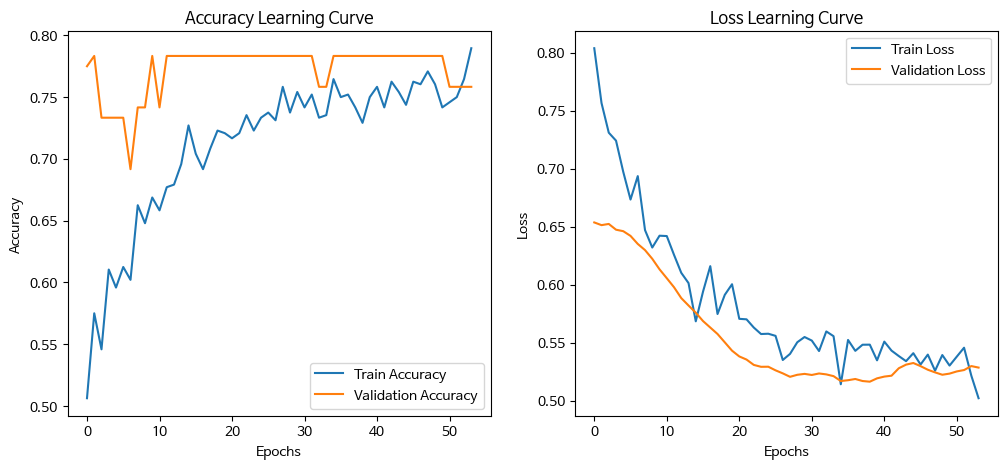

In [ ]:
import matplotlib.pyplot as plt

# 학습 곡선 시각화
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Learning Curve')

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Learning Curve')

    plt.show()

# 학습 곡선 시각화 호출
plot_learning_curves(history)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.6000
Recall: 0.1000
F1 Score: 0.1714


# 아노바 분석


EX
```
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 데이터 생성 예시
# 데이터 프레임에 'rating' (영화 등급), 'season' (개봉 시즌), 'audience_count' (관객 수) 컬럼이 있다고 가정
data = pd.DataFrame({
    'rating': ['15', '15', '청소년 관람불가', '청소년 관람불가', '전체 관람가', '전체 관람가'] * 10,
    'season': ['여름', '겨울', '여름', '겨울', '여름', '겨울'] * 10,
    'audience_count': [50000, 30000, 70000, 40000, 60000, 20000] * 10
})

# ANOVA 분석을 위한 모델 생성
# formula는 '종속변수 ~ 독립변수1 * 독립변수2' 형태
model = ols('audience_count ~ rating * season', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# 결과 출력
print(anova_table)
                    sum_sq    df         F          PR(>F)
rating         3.000000e+09   2.0  1.241417e+30     0.0
season         1.350000e+10   1.0  1.117276e+31     0.0
rating:season  1.000000e+09   2.0  4.138057e+29     0.0
Residual       6.524801e-20  54.0           NaN     NaN
```



- p-value = 0.05 에 따라 귀무 |대립 가설 판단

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import statsmodels.api as sm
import numpy as np

from statsmodels.formula.api import ols

# 데이터 로드
train = pd.read_csv('movies_train.csv')

train= train[['genre', 'release_time', 'screening_rat', 'box_off_num']]
# 장르 그룹화
target_genres = ['액션', '느와르', '공포', '서스펜스', '미스터리']
train['genre_grouped'] = train['genre'].apply(lambda x: 1 if x in target_genres else 0)

# 관람 등급 그룹화
train['screening_rat_G'] = train['screening_rat'].apply(lambda x: '청소년 관람불가' if x == '청소년 관람불가' else 'Other')

train['month'] = pd.to_datetime(train['release_time']).dt.month
train['season'] =  train['month'].apply(lambda x: '봄' if x in [3, 4, 5] else  ('여름' if x in [6, 7, 8] else ('가을' if x in [9, 10, 11] else '겨울')))
train['screening_rat_G'] = train['screening_rat'].apply(lambda x:x if '청소년 관람불가' else 'Other')
# formula는 '종속변수 ~ 독립변수1 * 독립변수2 * 독립변수3' 형태로 작성
model = ols('box_off_num ~ C(genre_grouped) + C(screening_rat) + C(season)', data=train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# 결과 출력
print(anova_table)

                        sum_sq     df          F    PR(>F)
C(genre_grouped)  4.737161e+13    1.0  15.603642  0.000088
C(screening_rat)  9.510863e+13    3.0  10.442549  0.000001
C(season)         3.615722e+13    3.0   3.969919  0.008095
Residual          1.797272e+15  592.0        NaN       NaN



**p-value 값이 모두 0.05 이하**로

독립변수( genre_grouped, screening_rat, season)

**귀무가설**- 각 독립변수가 box_off_num에 영향이 적다

**대립가설**- 각 독립변수가 box_off_num에 영향이 높다

그러므로 장르, 영화등급, 계절 변수가 관객수에 유의미한 영향이 있다

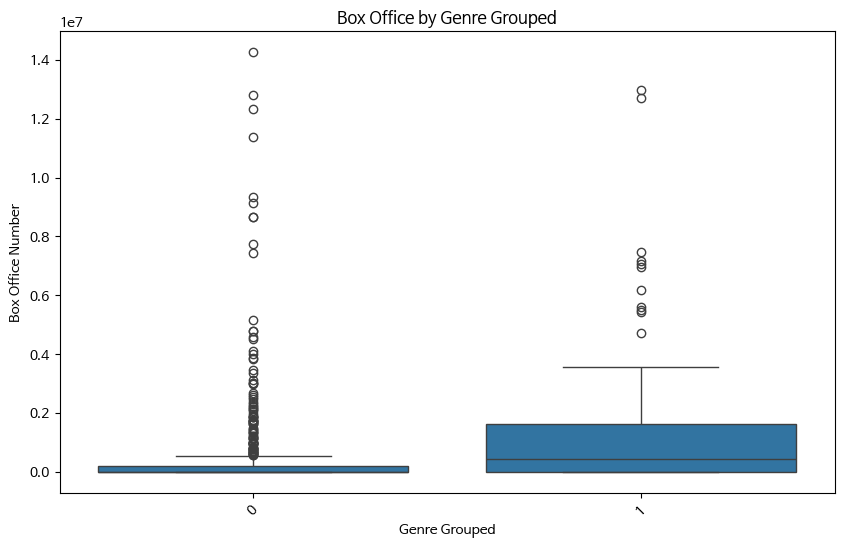

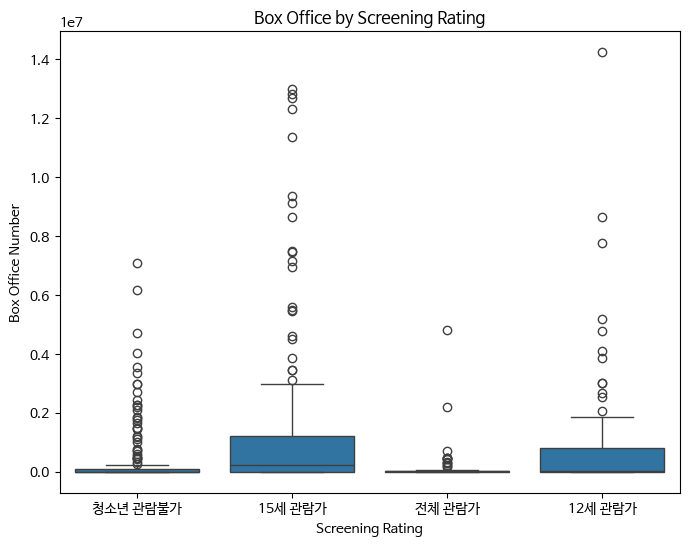

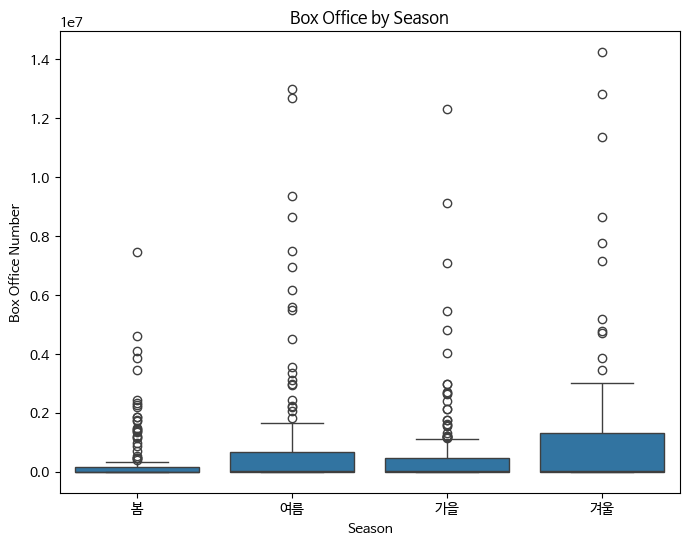

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# 1. 장르에 따른 박스 오피스 성과
plt.figure(figsize=(10, 6))
sns.boxplot(x='genre_grouped', y='box_off_num', data=train)
plt.title('Box Office by Genre Grouped')
plt.xlabel('Genre Grouped')
plt.ylabel('Box Office Number')
plt.xticks(rotation=45)
plt.show()

# 2. 상영 등급에 따른 박스 오피스 성과
plt.figure(figsize=(8, 6))
sns.boxplot(x='screening_rat_G', y='box_off_num', data=train)
plt.title('Box Office by Screening Rating')
plt.xlabel('Screening Rating')
plt.ylabel('Box Office Number')
plt.show()

# 3. 계절에 따른 박스 오피스 성과
plt.figure(figsize=(8, 6))
sns.boxplot(x='season', y='box_off_num', data=train, order=['봄', '여름', '가을', '겨울'])
plt.title('Box Office by Season')
plt.xlabel('Season')
plt.ylabel('Box Office Number')
plt.show()


<ipython-input-41-342c609aceac>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anova_table.index, y=anova_table['F'], palette='viridis')


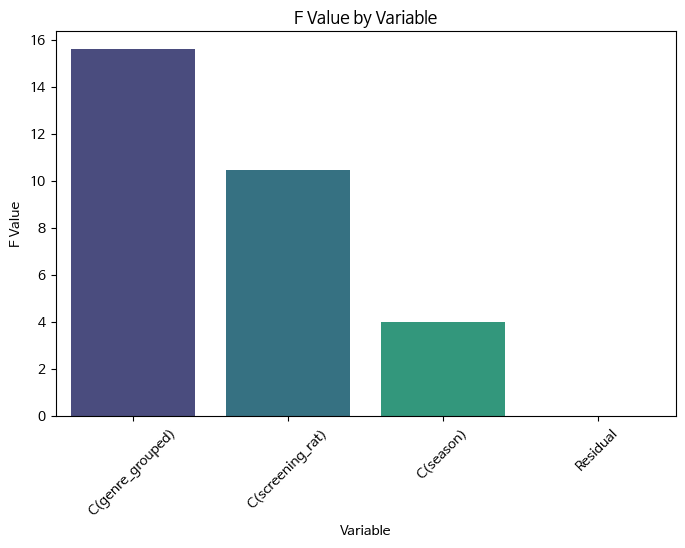

In [ ]:
# ANOVA 결과에서 F 값을 추출하여 시각화
anova_table = anova_table.sort_values(by='F', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=anova_table.index, y=anova_table['F'], palette='viridis')
plt.title('F Value by Variable')
plt.xlabel('Variable')
plt.ylabel('F Value')
plt.xticks(rotation=45)
plt.show()


# 회귀분석

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 데이터 로드
train = pd.read_csv('movies_train.csv')

# 필요한 열 선택 및 전처리
train = train[['genre', 'release_time', 'screening_rat', 'box_off_num']]
train['month'] = pd.to_datetime(train['release_time']).dt.month

# 계절 분류
train['season'] = train['month'].apply(lambda x: '봄' if x in [3, 4, 5] else
                                       ('여름' if x in [6, 7, 8] else
                                        ('가을' if x in [9, 10, 11] else '겨울')))

# 장르 그룹화
target_genres = ['액션', '느와르', '공포', '서스펜스', '미스터리']
train['genre_grouped'] = train['genre'].apply(lambda x: 1 if x in target_genres else 0)

# 관람 등급 그룹화
train['screening_rat_G'] = train['screening_rat'].apply(lambda x: '청소년 관람불가' if x == '청소년 관람불가' else 'Other')

# 범주형 변수를 더미 변수로 변환
train = pd.get_dummies(train, columns=['genre_grouped', 'screening_rat_G', 'season'], drop_first=True)

# 독립 변수와 종속 변수 정의
X = train.drop(columns=['box_off_num', 'genre', 'release_time', 'screening_rat', 'month'])
y = train['box_off_num']

# 상수항 추가 및 데이터 타입 변환
X = sm.add_constant(X).astype(float)
y = y.astype(float)

# 회귀 모델 피팅
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            box_off_num   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     10.16
Date:                Sat, 09 Nov 2024   Prob (F-statistic):           2.34e-09
Time:                        06:56:46   Log-Likelihood:                -9477.5
No. Observations:                 600   AIC:                         1.897e+04
Df Residuals:                     594   BIC:                         1.899e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   